In [3]:
import numpy as np
import polars as pl
import polars.selectors as cs
import seaborn as sns
from great_tables import GT
from kmodes.kprototypes import KPrototypes
from kmodes.util.dissim import euclidean_dissim, matching_dissim
from kneed import KneeLocator
from sklearn import config_context
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm

In [4]:
random_seed: int = 12
random_state: np.random.RandomState = np.random.RandomState(random_seed)
rng: np.random.Generator = np.random.default_rng(random_seed)

## K-Prototype

Let $\boldsymbol{X}=\left\{X_1, X_2, \ldots, X_n\right\} \in \mathbb{R}^{n\times m}$ denote a set of $n$ objects (rows of the data matrix) and let $X_i=\left[x_{i1}, x_{i2}, \ldots, x_{im}\right]\in\mathbb{R}^{1\times m}$ be an object represented by $m$ attribute (feature) values. Given a positive integer $k$, the goal of clustering $\boldsymbol{X}$ is to partition the objects into $k$ disjoint clusters.

* $n$ is the number of data points (rows) in the data matrix

* $m$ is the number of attributres or features (columns) in the data matrix

* $k$ is the number of clusters to be formed

---

### Cost Function

A general cost function for clustering is the trace of the within cluster dispersion matrix. One way to define this cost function is

$$
E=\sum_{l=1}^k \sum_{i=1}^n y_{i l} \cdot d \cdot \left(X_i, Q_l\right)
$$

where 

* $Q_l=\left[q_{l 1}, q_{l 2}, \ldots, q_{l m}\right]$ is the **representative vector** or **prototype** for cluster $l$
    * The centroid (mean) in K-means
    * The median in K-medians
    * A data point in K-mediods (a row in the data matrix)
* $y_{i l}$ is an element of a partition matrix $Y_{n \times k}$
* $d$ is a similarity measure between vectors $X_i$ in cluster $l$ and the prototype $Q_l$ of cluster $l$ often defined as the square Euclidean distance 

#### Partition Matrix Y

The matrix $Y \in\mathbb{R}^{n \times k}$ has the following two properties:

1. $0 \leq y_{i l} \leq 1$
2. $\sum_{l=1}^k y_{i l}=1$

The $Y$ is called a hard partition if $y_{i l} \in\{0,1\}$ (a binary matrix). In a hard partition, $y_{i l}=1$ indicates that object $X_i$ (think of it as a row in a data matrix) is assigned to cluster $l$ by $Y$.

---

### Concept of Prototypes (Numerical Features)

The inner summation term $E_l=\sum_{i=1}^n y_{i l} \cdot d \cdot \left(X_i, Q_l\right)$ in the cost function is **the total cost for cluster $l$**, i.e., the total **distances** of objects $X_{i}$ in cluster $l$ from its prototype $Q_l$. Each of the $k$ cost functions $E_l$ is minimized if

$$
q_{l j}=\frac{1}{n_l} \sum_{i=1}^n y_{i l} x_{i j} \quad \text { for } j=1, \ldots, m
$$

where $n_l=\sum_{i=1}^n y_{i l}$ is the number of objects or data points in cluster $l$. **Thus the numerical prototype equals the mean of the points in cluster $l$.**

> Intuitively, each prototype $q_{l j}$ is closest on average to all points in its cluster because it represents the **mean**, a natural measure of central tendency.

---

### Dissimilarity Measure for Mixed Data

When $\boldsymbol{X}$ contains categorical features, i.e., some of $m$ features is categorical, we can introduce a dissimilarity measure:

$$
d\left(X_i, Q_l\right)=\sum_{j=1}^{m_r}\left(x_{i j}^r-q_{l j}^r\right)^2+\gamma_l \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right)
$$

where

* $x_{i j}^r$ and $q_{l j}^r$ are values of numerical features and the **continuous prototype** of cluster $l$
* $x_{i j}^c$ and $q_{l j}^c$ are values of categorical features and the **categorical prototype** of cluster $l$
* $\delta\left(x_{i j}^c, q_{l j}^c\right)= \begin{cases}0 & \left(x_{i j}^c=q_{l j}^c \quad \text{matching} \right) \\ 1 & \left(x_{i j}^c \neq q_{l j}^c \quad \text{non-matching}\right)\end{cases}$
* $m_r$ and $m_c$ are the numbers of numerical and categorical features
* $\gamma_l$ is a weighting constant for categorical features for cluster $l$

> The $\delta$ function in this derivation is defined as the matching dissimilarity function. It is perfectly reasonable to use other dissimilarity functions. The `kmodes` package implements Jaccard dissimilarity and a dissimilarity proposed by Ng et all. (2007).
---

### Cost Function for Mixed Data

With this new dissimilarity measure, we can rewrite each of the $k$ inner summations $E_l$ as:

$$
\begin{aligned}
E_l & =\sum_{i=1}^n y_{il} \sum_{j=1}^{m_r}\left(x_{i j}^r-q_{l j}^r\right)^2+\gamma_l \sum_{i=1}^n y_{i l} \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right) \\
& =E_l^r+E_l^c
\end{aligned}
$$

where 

* $E_l^r$ is the total cost on all numerical features in cluster $l$
* $E_l^c$ is the total cost on all categorical features in cluster $l$

#### Lemma 1 For Minimizing $E_l^c$

Let $C_j$ be the set containing all unique values in the categorical feature $j$ and $p\left(c_j \in C_j \mid l\right)$ be the (conditional) probability of the category $c_j$ occurring in cluster $l$. The quantity $E_l^c$ in the equation above can be rewritten as

$$
E_l^c=\gamma_l \sum_{j=1}^{m_c} n_l\left(1-p\left(q_{l j}^c \in C_j \mid l\right)\right)
$$

where $n_l$ is the number of objects in cluster $l$. The proof that 

$$
E_l^c=\gamma_l \sum_{i=1}^n y_{i l} \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right)=\gamma_l \sum_{j=1}^{m_c} n_l\left(1-p\left(q_{l j}^c \in C_j \mid l\right)\right)
$$ 

is given in the appendix of the original paper. For a specific cluster $l$, the quantity $E_l^c$ is minimized if and only if 

$$
p\left(q_{l j}^c \in C_j \mid l\right) \geq p\left(c_j \in C_j \mid l\right)
$$ 

for $q_{l j}^c \neq c_j$ for all categorical features. 

> **In words, this means that the frequency (observed probability) of the prototype category $q_{l j}^c$ for categorical feature $j$ of cluster $l$ is greater than or equal to all other frequencies (observed probabilities) for all other categories $c_j$ of feature $j$, and this must be true for all categorical features $j$. Simply put, selecting the mode for every categorical feature minimises the categorical component of the cost function.**

To minimize $E_l^c$, we select each prototype value $q_{lj}^c$ so that its conditional probability $p\!\left(q_{lj}^c\in C_j \mid l\right)$ (shown in orange) is as large as possible (ideally close to 1):

$$
E_l^c=\gamma_l \sum_{j=1}^{m_c} n_l\left(1-\textcolor{orange}{p\left(q_{l j}^c \in C_j \mid l\right)}\right)
$$

When conditional probabilities are maximized (through finding the mode categories), the terms $\left(1-\textcolor{orange}{p\left(q_{l j}^c \in C_j \mid l\right)}\right)$ will be smaller, thus making the entire $E_l^c$ term smaller.

---

### Gamma

The weight $\gamma_l$ is introduced to avoid favouring either type of feature; if $\gamma_l=0$, clustering only depends on numerical features, i.e., locations of the
objects. In the `KPrototypes` implementation, this parameter is automatically calculated from the data. The formula and steps used to determine $\gamma_l$ is as follows in the original paper:

* Given the matrix $X_{\text{numerical}}$ of numerical features (excluding the categorical features), find the standard deviation of each column. So if $X_{\text{numerical}} \in \mathbb{R}^{n \times r}$ with $n$ rows and $r < m$ columns, we would obtain a vector of column standard deviations:

$$
\vec{sd}=\begin{bmatrix} \text{sd}_{\text{1}} \\ \text{sd}_{\text{2}} \\ \vdots \\ \text{sd}_{\text{r}} \end{bmatrix}
$$

* Take the mean of this vector $\text{mean}(\vec{sd})$, which is a scalar

* Multiply the mean standard deviation by $0.5$ to obtain the final estimate for $\gamma_{l}$

---

### Algorithm

The $k$-prototypes algorithm can be described as follows:

1. Randomly select $k$ initial prototypes $Q_l=\left[q_{l 1}, q_{l 2}, \ldots, q_{l m}\right]$ from a data set $\boldsymbol{X}$ with $n$ rows, one for each cluster $l$. Note that the number of clusters would have to specified a priori.
   
2. Allocate each data point (a row in a data matrix) in $\boldsymbol{X}$ to a cluster whose prototype $Q_l$ is the **nearest** to it according to the dissimilarity measure $d\left(X_i, Q_l\right)=\sum_{j=1}^{m_r}\left(x_{i j}^r-q_{l j}^r\right)^2+\gamma_l \sum_{j=1}^{m_c} \delta\left(x_{i j}^c, q_{l j}^c\right)$. Update the prototype of the cluster after each allocation, i.e., recalculate means for numerical features and find the modes for categorical features.
   
3. After all data points have been allocated to a cluster, recomopute the dissimilarities of data points against the all prototypes. If an object $X_{i} \in \mathbb{R}^{1 \times m}$ (a data point) in cluster $l$ is found such that its nearest prototype belongs to another cluster $t$ rather than its current one $l$, reallocate the object $X_{i} \in \mathbb{R}^{1 \times m}$ to that other cluster $t$ and update the prototypes of both clusters $t$ and $l$. 
   
4. Repeat (3) until no data point changes cluster (or the decrease in $E$ falls below a small tolerance).

The algorithm is built upon **three processes**:

* Initial prototypes selection
   
* Initial allocation

* Re-allocation

## Data

We'll simulate data with both numerical and categorical features:

* `charged_off_balance` is a lognormal distribution to simulate most balances being lower, i.e., a right-skewed distribution.
* `num_payments_current_month` is a poisson distribution to simulate the number of payments made in the current month.
* `tenure_months` is a uniform distribution to simulate the tenure of the account in months.
* `promise_to_pay` and `straight_roll` are binomial distributions for whether a promise to pay was made and whether the account is a straight roller, respectively.

In [5]:
n: int = 2_000

params = {
    "charged_off_balance": {"mean": 8, "sigma": 1.0},
    "num_payments_current_month": {"lam": 1.5},
    "tenure_months": {"low": 6, "high": 60},
    "promise_to_pay": {"p": 0.3},
    "straight_roll": {"p": 0.4},
}

data = pl.DataFrame(
    data={
        "charged_off_balance": rng.lognormal(
            mean=params["charged_off_balance"]["mean"],
            sigma=params["charged_off_balance"]["sigma"],
            size=n,
        ).round(4),
        "num_payments_current_month": rng.poisson(
            lam=params["num_payments_current_month"]["lam"], size=n
        ),
        "tenure_months": rng.integers(
            low=params["tenure_months"]["low"],
            high=params["tenure_months"]["high"] + 1,
            size=n,
        ),
        "promise_to_pay": rng.binomial(n=1, p=params["promise_to_pay"]["p"], size=n),
        "straight_roll": rng.binomial(n=1, p=params["straight_roll"]["p"], size=n),
    },
    schema={
        "charged_off_balance": pl.Float32,
        "num_payments_current_month": pl.Int32,
        "tenure_months": pl.Int32,
        "promise_to_pay": pl.Int8,
        "straight_roll": pl.Int8,
    },
)

Text(0.5, 1.02, 'Simulated Data')

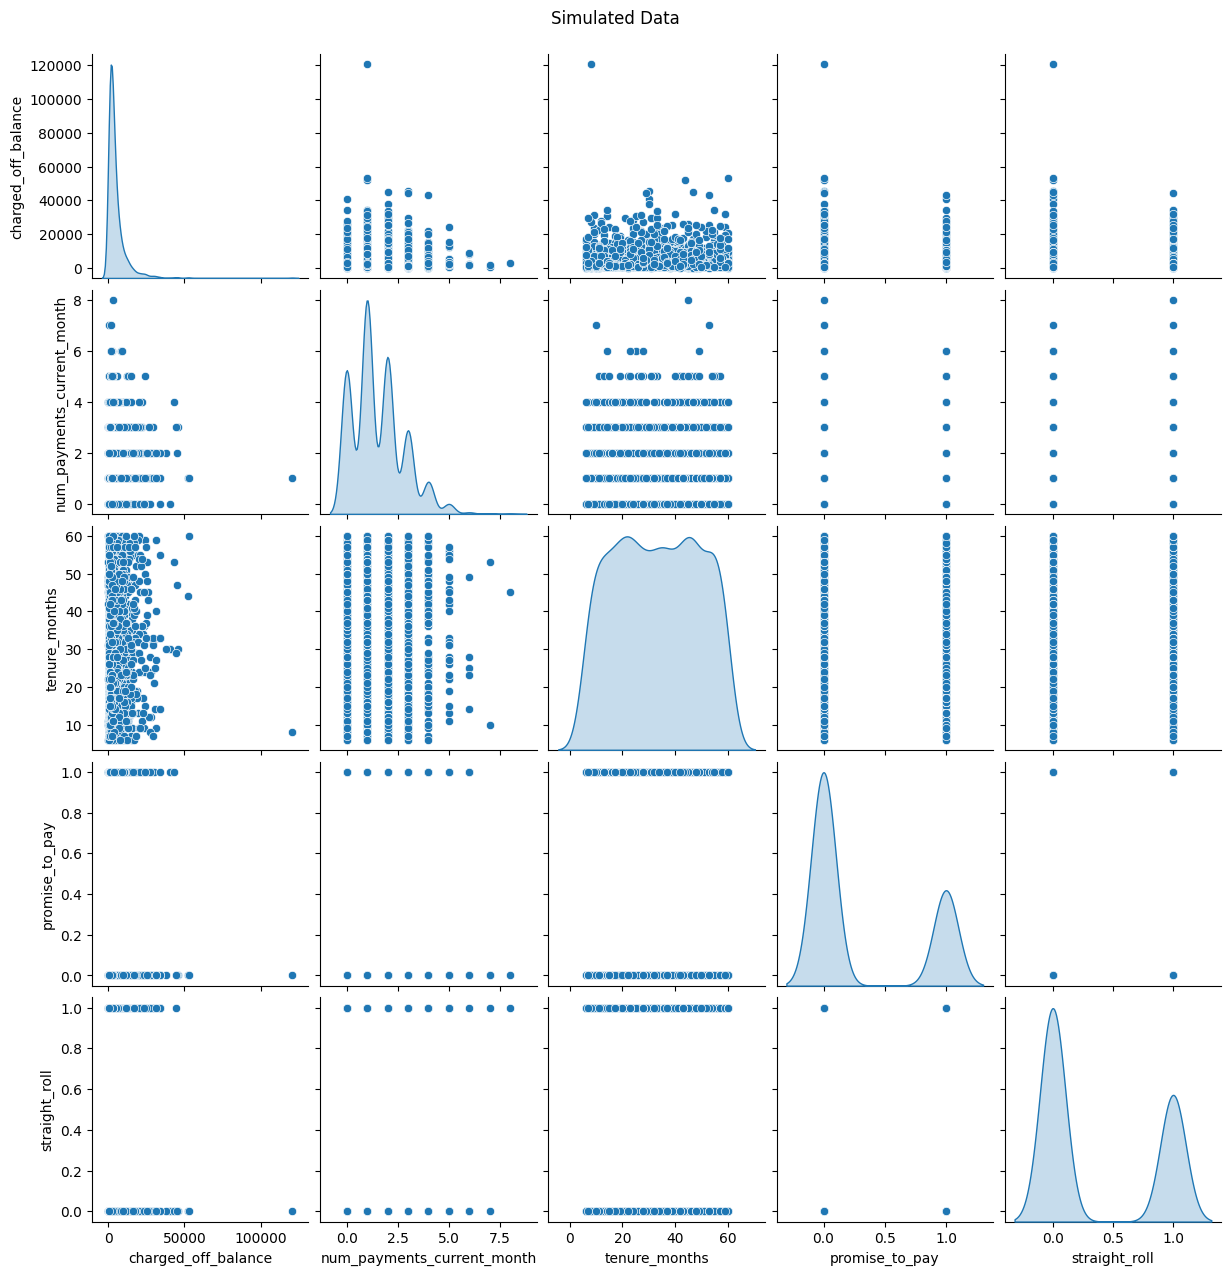

In [6]:
pairplot = sns.pairplot(
    data.to_pandas(),
    diag_kind="kde",
    height=2.5,
)
pairplot.figure.suptitle("Simulated Data", y=1.02)

## K-Prototypes with `kmodes`

In [7]:
num_cols = data.select(pl.col(pl.Float32, pl.Int32)).columns
cat_cols = data.select(pl.col(pl.Int8)).columns

cluster_pipeline = Pipeline(
    steps=[
        (
            "preprocessor",
            ColumnTransformer(
                transformers=[
                    (
                        "num",
                        RobustScaler(unit_variance=True),
                        num_cols,
                    ),
                    (
                        "cat",
                        "passthrough",
                        cat_cols,
                    ),
                ],
                n_jobs=-1,
                verbose_feature_names_out=False,
            ),
        )
    ]
)

with config_context(transform_output="polars"):
    X = cluster_pipeline.fit_transform(data)

X

charged_off_balance,num_payments_current_month,tenure_months,promise_to_pay,straight_roll
f64,f64,f64,i8,i8
0.004266,-1.34898,-0.399698,0,0
1.741325,-1.34898,-0.099924,0,0
1.040876,-1.34898,-0.649509,1,0
1.006491,0.0,-0.89932,1,1
3.803409,-1.34898,-0.849357,1,0
…,…,…,…,…
-0.701103,-1.34898,0.849357,0,1
2.117428,1.34898,0.999244,0,0
4.209278,1.34898,0.44966,1,0


### Balancing Contributions from Numerical and Categorical Features

A "balanced" global $\gamma$ makes the two contributions comparable:

$$
E^{r} \approx E^{c} = C_{\mathrm{r}} \approx \gamma C_{\mathrm{c}} \Longrightarrow \gamma^{\star}=\frac{C_{\mathrm{r}}}{C_{\mathrm{c}}}
$$

where 

* $C_{\mathrm{r}}$ cost contribution of numerical features
* $C_{\mathrm{c}}$ cost contribution of categorical features
* $\gamma^{\star}$ is an approximated global $\gamma$ value that balances the two contributions

In [20]:
X_num = X.select(num_cols)
X_cat = X.select(cat_cols)

# Averages for numerical columns
mu = X_num.mean().to_numpy()
mu = mu.reshape(1, -1)

# Modes for categorical columns
modes = X_cat.select(pl.all().mode()).to_numpy()
modes = modes.reshape(1, -1)

print(f"Numerical columns mean: {mu}")
print(f"Categorical columns mode: {modes}")

Numerical columns mean: [[0.64542899 0.69404995 0.00769418]]
Categorical columns mode: [[0 0]]


In [ ]:
mean_num_cost = euclidean_dissim(mu, X_num.to_numpy()).mean()
mean_cat_cost = matching_dissim(modes, X_cat.to_numpy()).mean()

# Mean
assert mean_num_cost > 0

gamma_star = float(mean_num_cost / mean_cat_cost)

print(f"Mean numerical columns cost: {mean_num_cost}")
print(f"Mean categorical columns cost: {mean_cat_cost}")
print(f"Approximate global gamma: {gamma_star}")

Mean numerical columns cost: 7.461848684376516
Mean categorical columns cost: 0.6815
Approximate global gamma: 10.949154342445365


### Number of Clusters

In [30]:
k_range = np.arange(2, 10)
total_costs = np.zeros_like(k_range, dtype=float)
cat_cols_indices = [data.get_column_index(col) for col in cat_cols]
X_array = X.to_numpy()

for i, k in enumerate(tqdm(k_range, desc="Number of clusters (k)", total=len(k_range))):
    kproto = KPrototypes(
        n_clusters=k,
        num_dissim=euclidean_dissim,
        cat_dissim=matching_dissim,
        random_state=random_state,
        gamma=gamma_star,
        n_jobs=-1,
    )
    kproto.fit(X=X_array, categorical=cat_cols_indices)
    total_costs[i] = kproto.cost_
    print(f"Cost for k = {k}: {total_costs[i]}")

Number of clusters (k):  12%|█▎        | 1/8 [00:02<00:15,  2.28s/it]

Cost for k = 2: 21686.000985128754


Number of clusters (k):  25%|██▌       | 2/8 [00:03<00:09,  1.51s/it]

Cost for k = 3: 17481.485540162386


Number of clusters (k):  38%|███▊      | 3/8 [00:03<00:04,  1.01it/s]

Cost for k = 4: 13692.482481210245


Number of clusters (k):  50%|█████     | 4/8 [00:04<00:03,  1.25it/s]

Cost for k = 5: 11177.779693354094


Number of clusters (k):  62%|██████▎   | 5/8 [00:04<00:02,  1.34it/s]

Cost for k = 6: 9449.731849113436


Number of clusters (k):  75%|███████▌  | 6/8 [00:05<00:01,  1.36it/s]

Cost for k = 7: 8646.857899703422


Number of clusters (k):  88%|████████▊ | 7/8 [00:06<00:00,  1.26it/s]

Cost for k = 8: 8108.914285334429


Number of clusters (k): 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]

Cost for k = 9: 7622.949605783395


In [31]:
kneedle = KneeLocator(
    x=k_range,
    y=total_costs,
    curve="convex",
    direction="decreasing",
)
print(f"Optimal k: {kneedle.elbow}")

Optimal k: 5


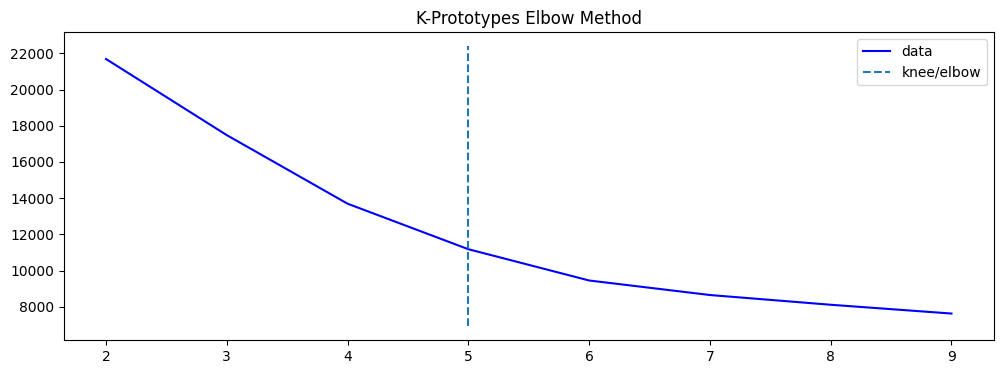

In [32]:
kneedle.plot_knee(figsize=(12, 4), title="K-Prototypes Elbow Method")

## Clusters Analysis

In [33]:
# Add the model to the pipeline
if "kproto" not in cluster_pipeline.named_steps:
    cluster_pipeline.steps.append(
        (
            "kproto",
            KPrototypes(
                n_clusters=kneedle.elbow,
                num_dissim=euclidean_dissim,
                cat_dissim=matching_dissim,
                random_state=random_state,
                gamma=gamma_star,
                n_jobs=-1,
            ),
        )
    )

cluster_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  RobustScaler(unit_variance=True),
                                                  ['charged_off_balance',
                                                   'num_payments_current_month',
                                                   'tenure_months']),
                                                 ('cat', 'passthrough',
                                                  ['promise_to_pay',
                                                   'straight_roll'])],
                                   verbose_feature_names_out=False)),
                ('kproto',
                 KPrototypes(gamma=10.949154342445365, n_clusters=np.int64(5),
                             n_jobs=-1,
                             random_state=RandomState(MT19937) at 0x17DFC5740))])

In [34]:
cluster_labels = cluster_pipeline.fit_predict(
    data, kproto__categorical=cat_cols_indices
)
data = data.with_columns(
    pl.Series(name="cluster", values=cluster_labels, dtype=pl.UInt32),
)

In [35]:
summary_table = (
    data.group_by("cluster")
    .agg(
        [
            pl.len().alias("n_accounts"),
            pl.all().exclude("cluster").mean().name.suffix("_mean"),
        ]
    )
    .sort("cluster")
)

GT(summary_table).tab_header(title="Cluster Profile Summary").fmt_number(
    columns=cs.float(), decimals=4
)

GT(_tbl_data=shape: (5, 7)
┌─────────┬────────────┬───────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ cluster ┆ n_accounts ┆ charged_off_b ┆ num_payments ┆ tenure_month ┆ promise_to_p ┆ straight_rol │
│ ---     ┆ ---        ┆ alance_mean   ┆ _current_mon ┆ s_mean       ┆ ay_mean      ┆ l_mean       │
│ u32     ┆ u32        ┆ ---           ┆ th_mea…      ┆ ---          ┆ ---          ┆ ---          │
│         ┆            ┆ f64           ┆ ---          ┆ f64          ┆ f64          ┆ f64          │
│         ┆            ┆               ┆ f64          ┆              ┆              ┆              │
╞═════════╪════════════╪═══════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 0       ┆ 827        ┆ 3797.753023   ┆ 1.484885     ┆ 33.241838    ┆ 0.0          ┆ 0.0          │
│ 1       ┆ 238        ┆ 3758.669118   ┆ 1.563025     ┆ 33.033613    ┆ 1.0          ┆ 1.0          │
│ 2       ┆ 478        ┆ 4122.254707   ┆ 1.518828     ┆ 33.74477     ┆ 0.0          ┆ 1.0          │
│ 3       ┆ 357        ┆ 4091.482143   ┆ 1.571429     ┆ 32.184874    ┆ 1.0          ┆ 0.0          │
│ 4       ┆ 100        ┆ 25336.535     ┆ 1.42         ┆ 33.35        ┆ 0.23         ┆ 0.29         │
└─────────┴────────────┴───────────────┴──────────────┴──────────────┴──────────────┴──────────────┘, _body=<great_tables._gt_data.Body object at 0x17f283080>, _boxhead=Boxhead([ColInfo(var='cluster', type=<ColInfoTypeEnum.default: 1>, column_label='cluster', column_align='right', column_width=None), ColInfo(var='n_accounts', type=<ColInfoTypeEnum.default: 1>, column_label='n_accounts', column_align='right', column_width=None), ColInfo(var='charged_off_balance_mean', type=<ColInfoTypeEnum.default: 1>, column_label='charged_off_balance_mean', column_align='right', column_width=None), ColInfo(var='num_payments_current_month_mean', type=<ColInfoTypeEnum.default: 1>, column_label='num_payments_current_month_mean', column_align='right', column_width=None), ColInfo(var='tenure_months_mean', type=<ColInfoTypeEnum.default: 1>, column_label='tenure_months_mean', column_align='right', column_width=None), ColInfo(var='promise_to_pay_mean', type=<ColInfoTypeEnum.default: 1>, column_label='promise_to_pay_mean', column_align='right', column_width=None), ColInfo(var='straight_roll_mean', type=<ColInfoTypeEnum.default: 1>, column_label='straight_roll_mean', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17f19d1f0>, _spanners=Spanners([]), _heading=Heading(title='Cluster Profile Summary', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x3061ae2a0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x17f19ca40>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='val